# **Medical Cost Prediction: Machine Learning Workflow for Regression Tasks**

## Overview
##### This notebook is an step-by-step instruction to train a machine learning model to prediction medical insurance cost based on insrued age, sex, BMI, children, smoking history, and region in the United States. Following topics will be discussed:

##### 1. Python packages requirements
##### 2. Loading data and exploratory data analsys (EDA)
##### 3. Data cleaning and preprocessing
##### 4. Model training and optimization 
##### 5. Model evaluation using key metrics

##### **1. Python packages requirements**

In [215]:
# Loading data
import numpy as np 
import pandas as pd 

# Exploratory data analsys (EDA) 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Data cleaning and preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, SplineTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Model training 
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

# Model evaluation 
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error

In [216]:
warnings.filterwarnings('ignore')

##### **2. Loading data and exploratory data analsys (EDA)**

In [217]:
"""
# 2. Load data
"""
sudhirln92_csv = 'https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/refs/heads/master/insurance.csv'
try:
    df = pd.read_csv(sudhirln92_csv)
    source = 'https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/README.md'
except Exception:
    repo_csv = '../data/medical_cost_personal_datasets.csv'
    df = pd.read_csv(repo_csv)
    source = 'SWB_Predictive_Analytics_Machine_Leanring raw CSV'

print('Data source:', source)
print('Shape:', df.shape)
df.head()


Data source: https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/README.md
Shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


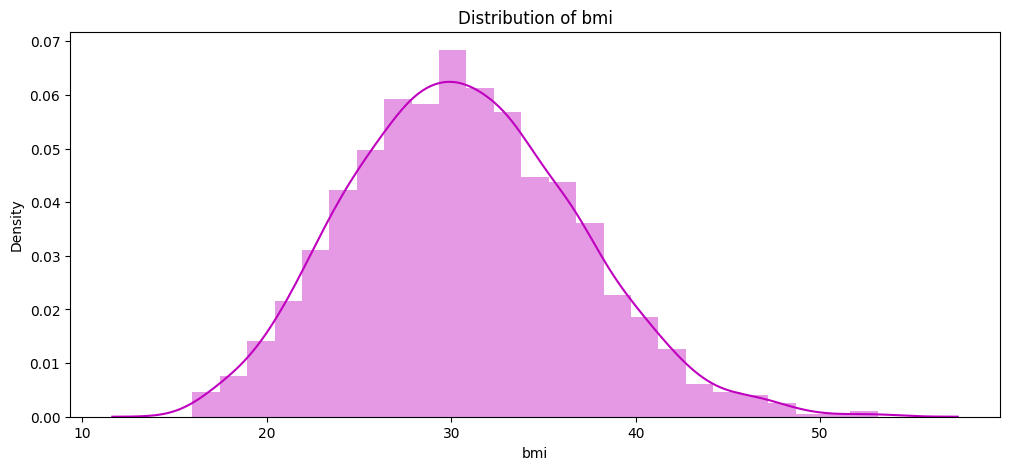

In [219]:
plt.figure(figsize=(12,5))
plt.title("Distribution of bmi")
ax = sns.distplot(df["bmi"], color = 'm')

##### **3. Data cleaning**

In [220]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [221]:
# preprocessing for plotting
#sex
le = LabelEncoder()
le.fit(df.sex.drop_duplicates()) 
df.sex = le.transform(df.sex)
# smoker or not
le.fit(df.smoker.drop_duplicates()) 
df.smoker = le.transform(df.smoker)
#region
le.fit(df.region.drop_duplicates()) 
df.region = le.transform(df.region)

In [222]:
for index, class_label in enumerate(le.classes_):
    print(f"{class_label} -> {index}")

northeast -> 0
northwest -> 1
southeast -> 2
southwest -> 3


In [223]:
df.corr()['charges'].sort_values()

region     -0.006208
sex         0.057292
children    0.067998
bmi         0.198341
age         0.299008
smoker      0.787251
charges     1.000000
Name: charges, dtype: float64

Text(0.5, 1.0, 'Distribution of charges for non-smokers')

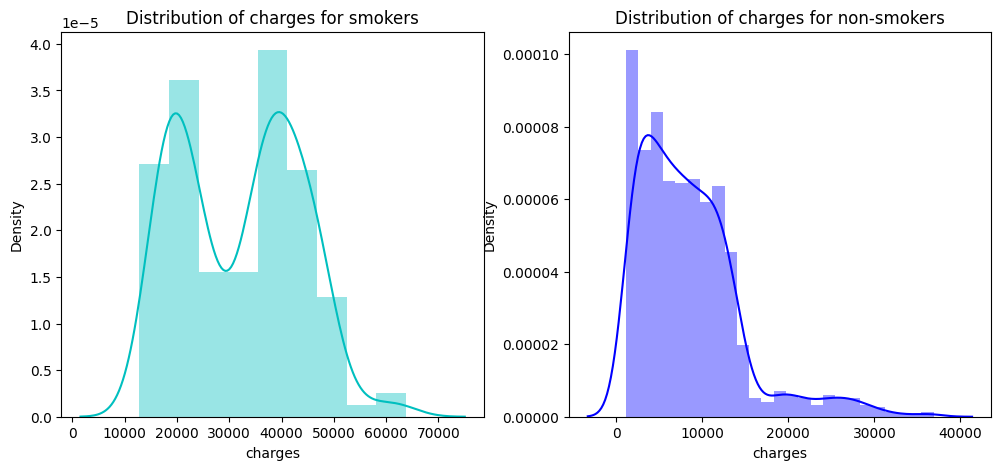

In [224]:
# plotting

f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(df[(df.smoker == 1)]["charges"],color='c',ax=ax)
ax.set_title('Distribution of charges for smokers')

ax=f.add_subplot(122)
sns.distplot(df[(df.smoker == 0)]['charges'],color='b',ax=ax)
ax.set_title('Distribution of charges for non-smokers')

<Axes: >

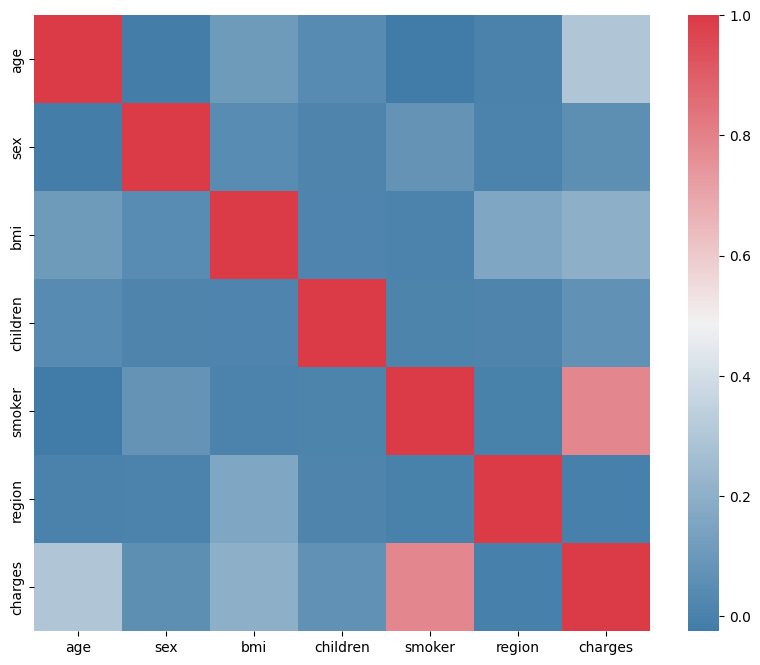

In [225]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)

##### **3. Data preprocessing**

In [226]:
# define X and y columns for regression 
X = df.drop(['charges'], axis = 1)
y = df.charges

# divide X and y into training and testing datasets. 
# The training dataset is used to train/calibrate the model. 
# The test data set is used to test the trained model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [227]:
# initialize a Linear Regression object
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_train, y_train)

0.7521877761879816

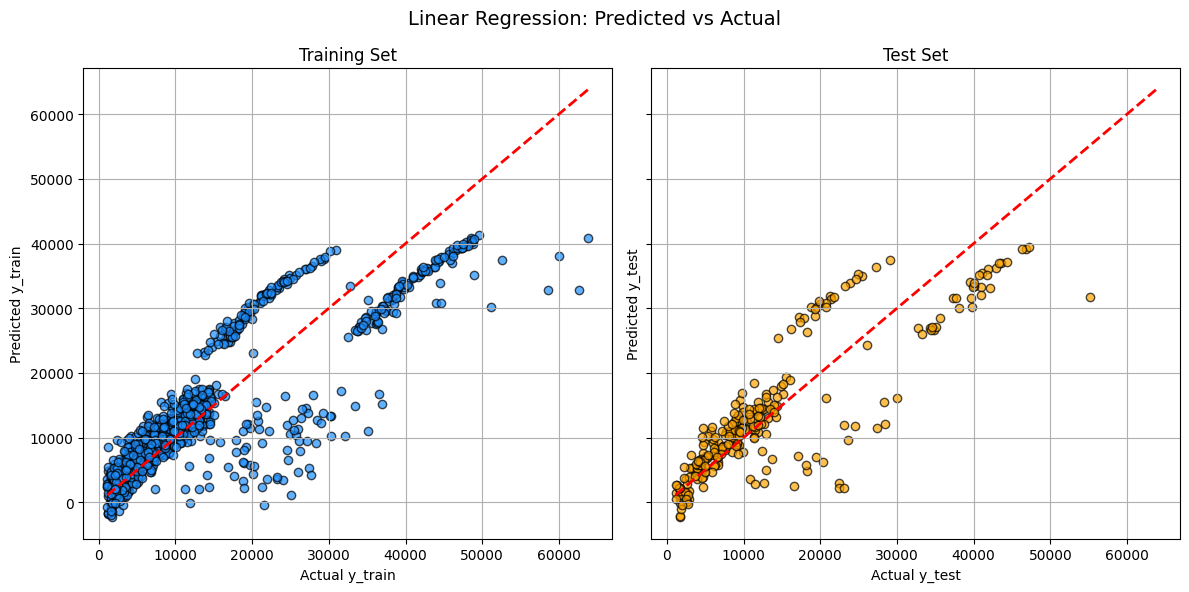

In [228]:
# predict using the trained model
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# Plot predicted vs actual
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Define common limits for both plots
y_min = min(y_train.min(), y_test.min())
y_max = max(y_train.max(), y_test.max())

# --- Left: Training set ---
axes[0].scatter(y_train, y_pred_train, color="dodgerblue", alpha=0.7, edgecolor="k")
axes[0].plot([y_min, y_max], [y_min, y_max], 'r--', lw=2)
axes[0].set_title("Training Set")
axes[0].set_xlabel("Actual y_train")
axes[0].set_ylabel("Predicted y_train")
axes[0].grid(True)

# --- Right: Test set ---
axes[1].scatter(y_test, y_pred_test, color="orange", alpha=0.7, edgecolor="k")
axes[1].plot([y_min, y_max], [y_min, y_max], 'r--', lw=2)
axes[1].set_title("Test Set")
axes[1].set_xlabel("Actual y_test")
axes[1].set_ylabel("Predicted y_test")
axes[1].grid(True)

# Overall title and layout
fig.suptitle("Linear Regression: Predicted vs Actual", fontsize=14)
plt.tight_layout()
plt.show()

In [229]:
# preprocess each variable in the X data sets. 
# without preprocessing, columns with bigger values would dominate the model training. 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# initialize a Linear Regression object
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)
lr.score(X_train_scaled, y_train)

0.7521877761879817

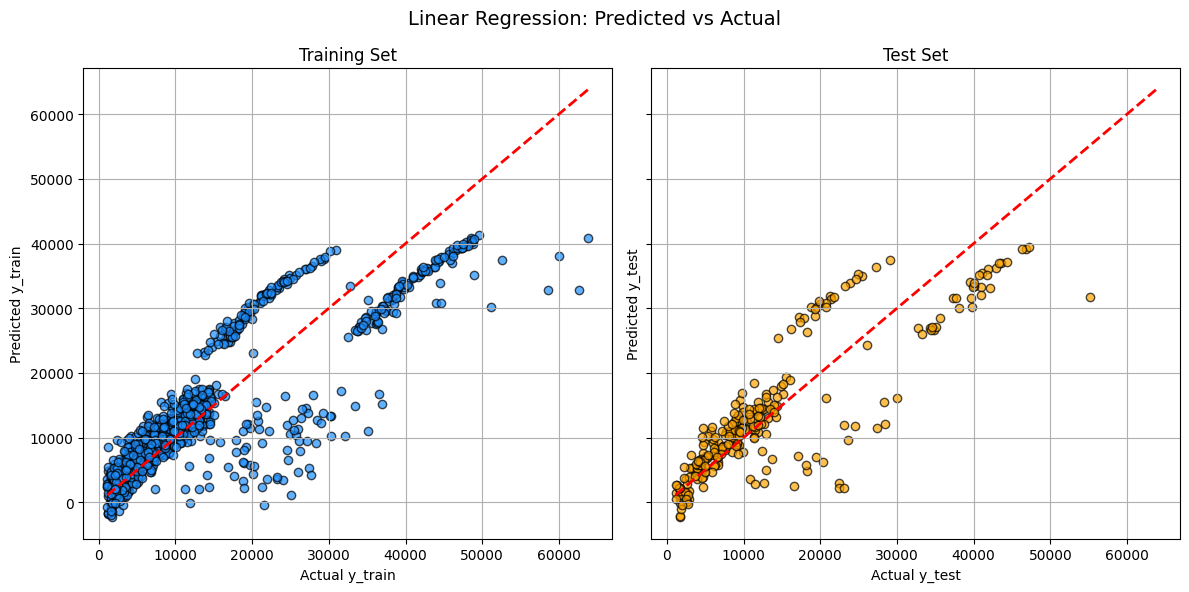

In [230]:
# predict using the trained model
y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)

# Plot predicted vs actual
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Define common limits for both plots
y_min = min(y_train.min(), y_test.min())
y_max = max(y_train.max(), y_test.max())

# --- Left: Training set ---
axes[0].scatter(y_train, y_pred_train, color="dodgerblue", alpha=0.7, edgecolor="k")
axes[0].plot([y_min, y_max], [y_min, y_max], 'r--', lw=2)
axes[0].set_title("Training Set")
axes[0].set_xlabel("Actual y_train")
axes[0].set_ylabel("Predicted y_train")
axes[0].grid(True)

# --- Right: Test set ---
axes[1].scatter(y_test, y_pred_test, color="orange", alpha=0.7, edgecolor="k")
axes[1].plot([y_min, y_max], [y_min, y_max], 'r--', lw=2)
axes[1].set_title("Test Set")
axes[1].set_xlabel("Actual y_test")
axes[1].set_ylabel("Predicted y_test")
axes[1].grid(True)

# Overall title and layout
fig.suptitle("Linear Regression: Predicted vs Actual", fontsize=14)
plt.tight_layout()
plt.show()

In [231]:
# using polynomial features to preprocess the X_train
poly = PolynomialFeatures(degree=4)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# initialize a Linear Regression object
lr = LinearRegression()
lr.fit(X_train_poly, y_train)
lr.score(X_train_poly, y_train)

0.8730832225918013

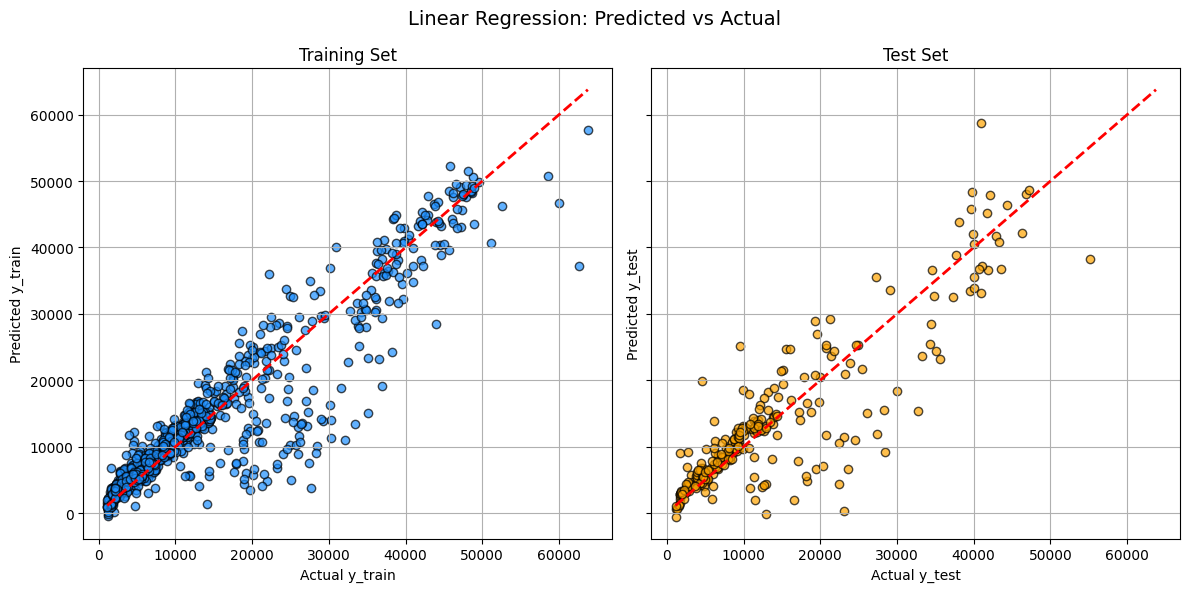

In [232]:
# predict using the trained model
y_pred_train = lr.predict(X_train_poly)
y_pred_test = lr.predict(X_test_poly)

# Plot predicted vs actual
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Define common limits for both plots
y_min = min(y_train.min(), y_test.min())
y_max = max(y_train.max(), y_test.max())

# --- Left: Training set ---
axes[0].scatter(y_train, y_pred_train, color="dodgerblue", alpha=0.7, edgecolor="k")
axes[0].plot([y_min, y_max], [y_min, y_max], 'r--', lw=2)
axes[0].set_title("Training Set")
axes[0].set_xlabel("Actual y_train")
axes[0].set_ylabel("Predicted y_train")
axes[0].grid(True)

# --- Right: Test set ---
axes[1].scatter(y_test, y_pred_test, color="orange", alpha=0.7, edgecolor="k")
axes[1].plot([y_min, y_max], [y_min, y_max], 'r--', lw=2)
axes[1].set_title("Test Set")
axes[1].set_xlabel("Actual y_test")
axes[1].set_ylabel("Predicted y_test")
axes[1].grid(True)

# Overall title and layout
fig.suptitle("Linear Regression: Predicted vs Actual", fontsize=14)
plt.tight_layout()
plt.show()

In [233]:
# Build pipeline to fascilitate implementing multiple preprocessing - streamline your model and preprocessing, ...
model = Pipeline([
    ('poly', PolynomialFeatures(degree=4)),
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# Fit on training data
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.8730832225918013

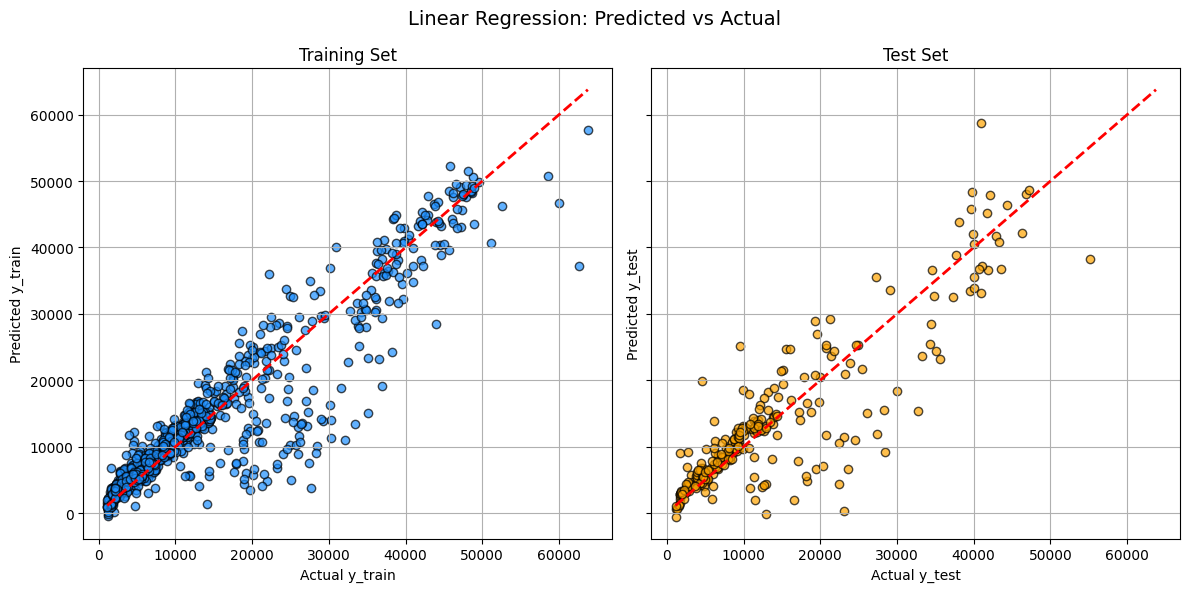

In [234]:
# predict using the trained model
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Plot predicted vs actual
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Define common limits for both plots
y_min = min(y_train.min(), y_test.min())
y_max = max(y_train.max(), y_test.max())

# --- Left: Training set ---
axes[0].scatter(y_train, y_pred_train, color="dodgerblue", alpha=0.7, edgecolor="k")
axes[0].plot([y_min, y_max], [y_min, y_max], 'r--', lw=2)
axes[0].set_title("Training Set")
axes[0].set_xlabel("Actual y_train")
axes[0].set_ylabel("Predicted y_train")
axes[0].grid(True)

# --- Right: Test set ---
axes[1].scatter(y_test, y_pred_test, color="orange", alpha=0.7, edgecolor="k")
axes[1].plot([y_min, y_max], [y_min, y_max], 'r--', lw=2)
axes[1].set_title("Test Set")
axes[1].set_xlabel("Actual y_test")
axes[1].set_ylabel("Predicted y_test")
axes[1].grid(True)

# Overall title and layout
fig.suptitle("Linear Regression: Predicted vs Actual", fontsize=14)
plt.tight_layout()
plt.show()

##### **4. Cross-Validation and Hyperparameter Optimization**

In [235]:
# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=99)

# Evaluate with R² score
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

print("Cross-validation R² scores:", scores)
print("Mean R²:", np.mean(scores))

Cross-validation R² scores: [0.83339311 0.78048045 0.81224763 0.39145914 0.74229223]
Mean R²: 0.7119745128345003


In [236]:
param_grid = {
    'poly__degree': [1, 2, 3, 4, 5, 6]
}

grid = GridSearchCV(model, param_grid, cv=cv, scoring='r2')
grid.fit(X_train, y_train)

print("Best degree:", grid.best_params_['poly__degree'])
print("Best CV R²:", grid.best_score_)

Best degree: 2
Best CV R²: 0.8367534242074015


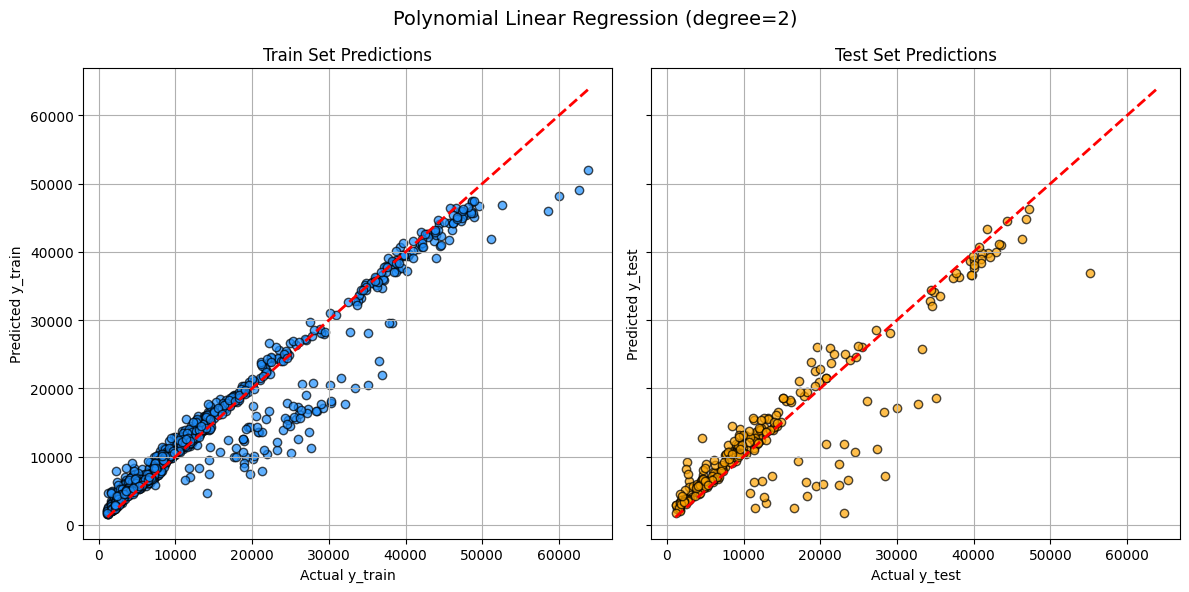

In [237]:
# Predict on train and test sets
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Plot predicted vs actual side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Common limits
y_min = min(y_train.min(), y_test.min())
y_max = max(y_train.max(), y_test.max())

# --- Train ---
axes[0].scatter(y_train, y_pred_train, color="dodgerblue", alpha=0.7, edgecolor="k")
axes[0].plot([y_min, y_max], [y_min, y_max], 'r--', lw=2)
axes[0].set_title("Train Set Predictions")
axes[0].set_xlabel("Actual y_train")
axes[0].set_ylabel("Predicted y_train")
axes[0].grid(True)

# --- Test ---
axes[1].scatter(y_test, y_pred_test, color="orange", alpha=0.7, edgecolor="k")
axes[1].plot([y_min, y_max], [y_min, y_max], 'r--', lw=2)
axes[1].set_title("Test Set Predictions")
axes[1].set_xlabel("Actual y_test")
axes[1].set_ylabel("Predicted y_test")
axes[1].grid(True)

# Figure title
fig.suptitle(f"Polynomial Linear Regression (degree={grid.best_params_['poly__degree']})", fontsize=14)
plt.tight_layout()
plt.show()

##### **5. Tree-based Models**

In [238]:
# Define pipeline
model = Pipeline([
    ('rf', RandomForestRegressor(random_state=99))
])

# Parameter grid for RandomForest
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2']
}

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
grid = GridSearchCV(model, param_grid, cv=cv, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

# Correct print statements
print("Best Parameters:", grid.best_params_)
print("Best CV R²:", grid.best_score_)

Best Parameters: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
Best CV R²: 0.8474616005648834


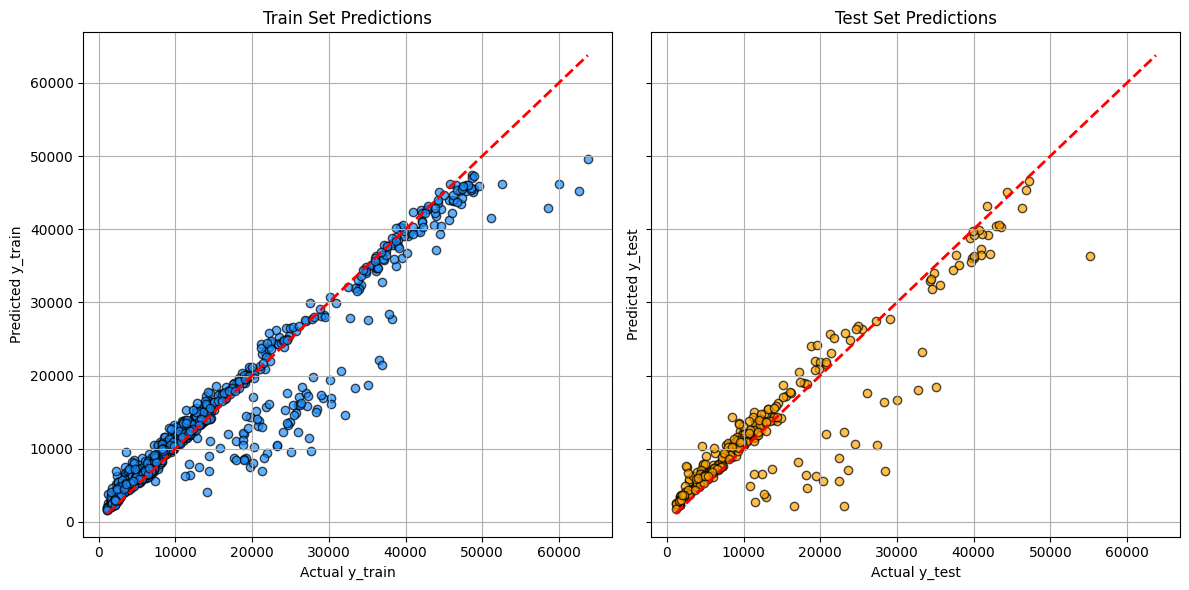

In [239]:
best_model = grid.best_estimator_

# Predict on train and test sets
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Plot predicted vs actual side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Common limits
y_min = min(y_train.min(), y_test.min())
y_max = max(y_train.max(), y_test.max())

# --- Train ---
axes[0].scatter(y_train, y_pred_train, color="dodgerblue", alpha=0.7, edgecolor="k")
axes[0].plot([y_min, y_max], [y_min, y_max], 'r--', lw=2)
axes[0].set_title("Train Set Predictions")
axes[0].set_xlabel("Actual y_train")
axes[0].set_ylabel("Predicted y_train")
axes[0].grid(True)

# --- Test ---
axes[1].scatter(y_test, y_pred_test, color="orange", alpha=0.7, edgecolor="k")
axes[1].plot([y_min, y_max], [y_min, y_max], 'r--', lw=2)
axes[1].set_title("Test Set Predictions")
axes[1].set_xlabel("Actual y_test")
axes[1].set_ylabel("Predicted y_test")
axes[1].grid(True)

# Figure title
plt.tight_layout()
plt.show()

##### **6. Model Evaludation**

In [240]:
# define metrics that is used to evaluate models' training
scoring = {
    'R2': make_scorer(r2_score),
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))
}

# Grid search
grid = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, refit='R2', n_jobs=-1)
grid.fit(X_train, y_train)

# Correct print statements
print("Best Parameters:", grid.best_params_)
print("Best CV R²:", grid.best_score_)

Best Parameters: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
Best CV R²: 0.8474616005648834


In [241]:
cv_results = grid.cv_results_
pd.DataFrame(grid.cv_results_)[
    ['mean_test_R2', 'mean_test_MAE', 'mean_test_MSE', 'mean_test_RMSE', 'params']
]

,mean_test_R2,mean_test_MAE,mean_test_MSE,mean_test_RMSE,params
0,0.842972,2769.863494,2.304908e+07,4747.200321,"{'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}"
1,0.846824,2696.262752,2.245888e+07,4683.413997,"{'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}"
2,0.843195,2847.147553,2.303370e+07,4746.656949,"{'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}"
3,0.847247,2767.033207,2.240963e+07,4679.267376,"{'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}"
4,0.841185,2972.472322,2.332243e+07,4784.373774,"{'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}"
...,...,...,...,...,...
103,0.840997,2966.123094,2.331741e+07,4781.193105,"{'rf__max_depth': 30, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}"
104,0.837100,3006.920568,2.391179e+07,4843.853139,"{'rf__max_depth': 30, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}"
105,0.840997,2966.123094,2.331741e+07,4781.193105,"{'rf__max_depth': 30, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}"
106,0.830742,3111.236786,2.481214e+07,4935.468128,"{'rf__max_depth': 30, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}"


##### **7. Comparing Multiple Models**

In [242]:
# use gridsearch with pipeline tool to compare multiple machine learning models
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
        }
    },
    'PLSRegression': {
        'model': PLSRegression(),
        'params': {
            'regressor__n_components': [1, 2, 3, 4, 5, 6]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=1, criterion = 'squared_error'),
        'params': {
            'regressor__n_estimators': [100, 200],
            'regressor__min_samples_split': [2, 4, 6],
            'regressor__min_samples_leaf': [1, 2, 3]
        }
    },
    'HistGradientBoosting': {
        'model': HistGradientBoostingRegressor(random_state=42),
        'params': {
            'regressor__learning_rate': [0.01, 0.02, 0.03],
            'regressor__max_iter': [100, 200],
            'regressor__max_depth': [10, 20],
            'regressor__l2_regularization': [0.1, 0.2, 0.5]
        }
    }
}


In [243]:
results = []
best_models = {}

for name, config in models.items():
    print(f"Training {name}...")

    pipeline = Pipeline([
        ('scaler', PolynomialFeatures(degree=3, include_bias=False)),
        ('regressor', config['model'])
    ])
    
    grid = GridSearchCV(pipeline,
                        param_grid=config['params'],
                        scoring='r2',
                        cv=cv,
                        n_jobs=-1,
                        verbose=0)

    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    best_models[name] = best_model
    
     # --- Cross-validated training metrics ---
    train_scores = cross_validate(best_model, X_train, y_train, cv=cv, scoring={
        'R2': 'r2',
        'MAE': 'neg_mean_absolute_error',
        'MSE': 'neg_mean_squared_error'
    })

    # Average cross-validated scores
    r2_train = np.mean(train_scores['test_R2'])
    mae_train = -np.mean(train_scores['test_MAE'])
    mse_train = -np.mean(train_scores['test_MSE'])
    rmse_train = np.sqrt(mse_train)

    # --- Test metrics ---
    y_pred_test = best_model.predict(X_test)
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)

    # --- Collect results ---
    results.append({
        'Model': name,
        'Best Params': best_params,
        'Train R2': round(r2_train, 4),
        'Train MAE': round(mae_train, 4),
        'Train RMSE': round(rmse_train, 4),
        'Test R2': round(r2_test, 4),
        'Test MAE': round(mae_test, 4),
        'Test RMSE': round(rmse_test, 4)
    })

Training LinearRegression...
Training PLSRegression...
Training RandomForest...
Training HistGradientBoosting...


In [244]:
results_df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)
print(results_df.sort_values(by='Test R2', ascending=False).reset_index(drop=True))

                  Model  \
0          RandomForest   
1  HistGradientBoosting   
2      LinearRegression   
3         PLSRegression   

                                                                                                                       Best Params  \
0                            {'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}   
1  {'regressor__l2_regularization': 0.5, 'regressor__learning_rate': 0.03, 'regressor__max_depth': 10, 'regressor__max_iter': 100}   
2                                                                                                                               {}   
3                                                                                                   {'regressor__n_components': 6}   

   Train R2  Train MAE  Train RMSE  Test R2   Test MAE  Test RMSE  
0    0.8504  2583.6103   4677.8769   0.8373  2683.5604  4784.8574  
1    0.8537  2594.5887   4627.9916   0.8373  2682.4264  4

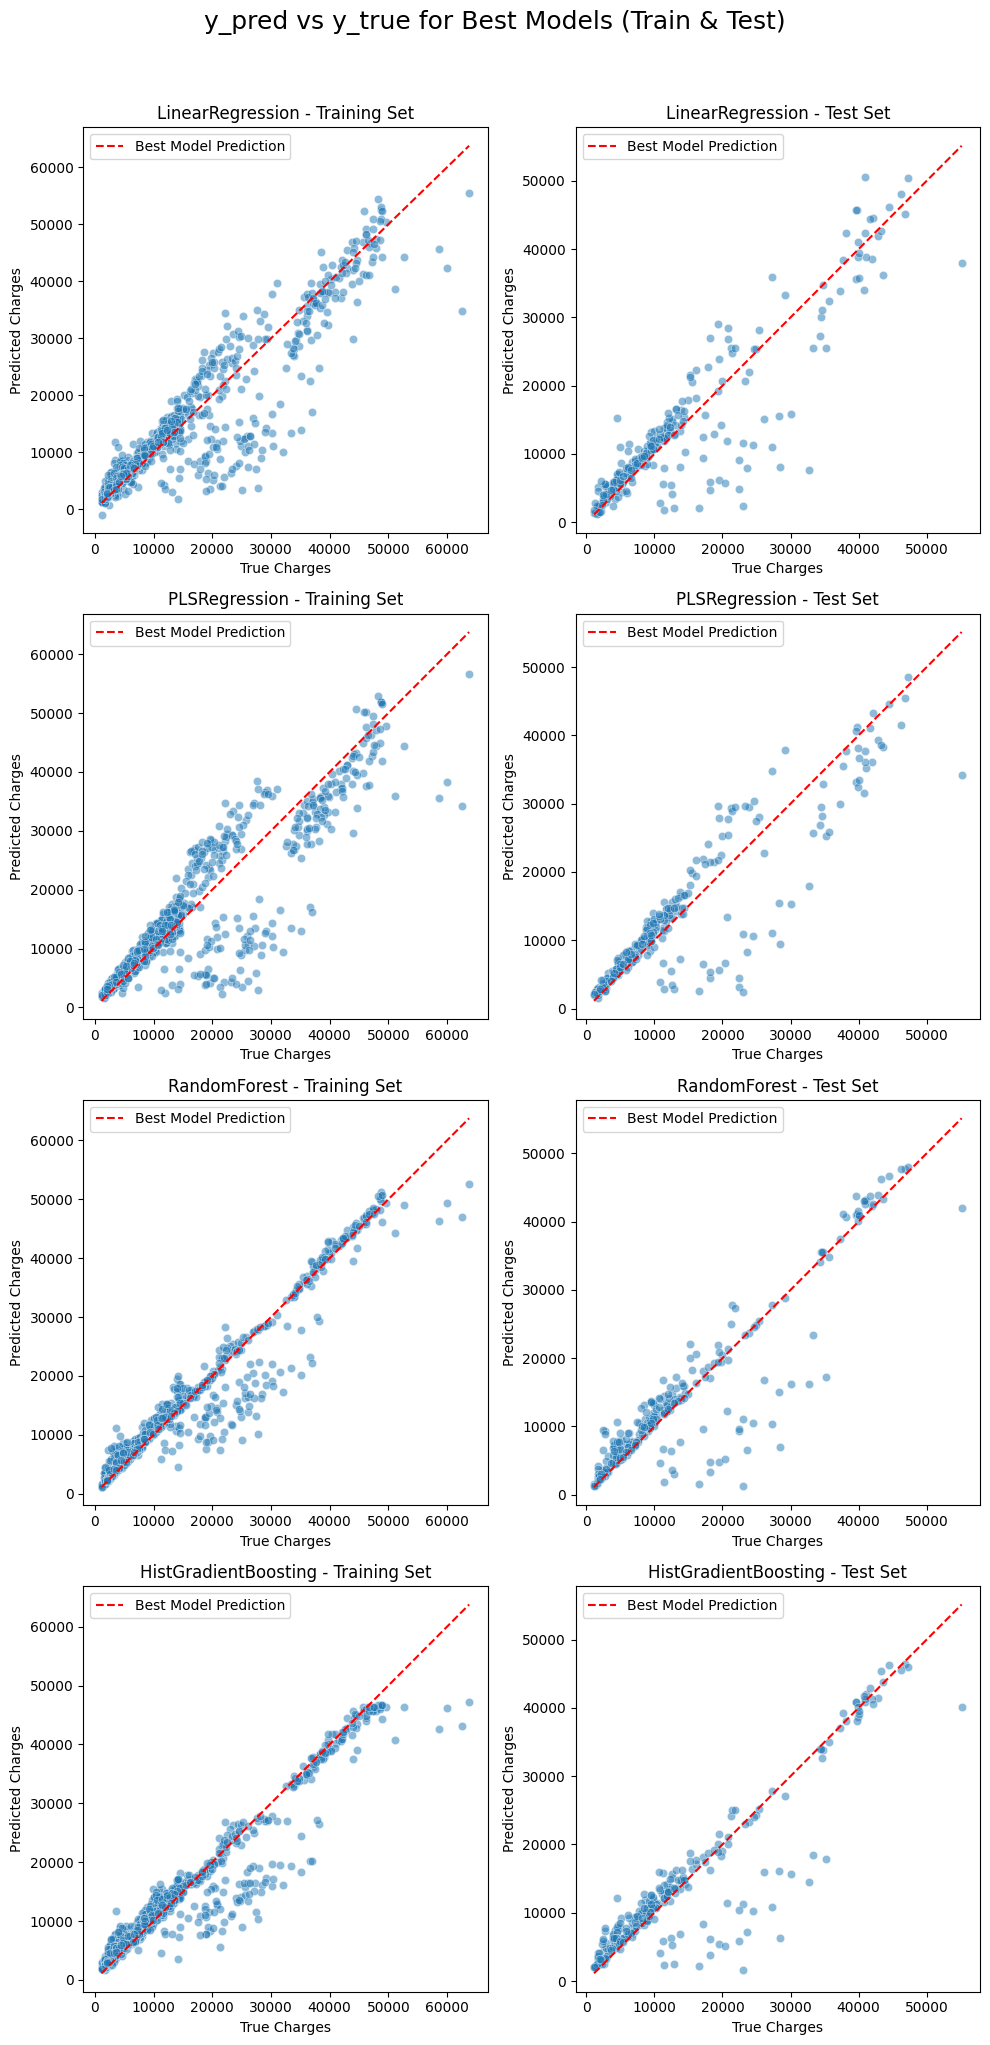

In [245]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
axes = axes.flatten()

for i, (name, model) in enumerate(best_models.items()):
    # Train predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # --- Training set plot ---
    ax_train = axes[2 * i]
    sns.scatterplot(x=y_train, y=y_pred_train, ax=ax_train, alpha=0.5)
    ax_train.plot([y_train.min(), y_train.max()],
                  [y_train.min(), y_train.max()],
                  'r--', label='Best Model Prediction')
    ax_train.set_title(f'{name} - Training Set')
    ax_train.set_xlabel('True Charges')
    ax_train.set_ylabel('Predicted Charges')
    ax_train.legend()

    # --- Test set plot ---
    ax_test = axes[2 * i + 1]
    sns.scatterplot(x=y_test, y=y_pred_test, ax=ax_test, alpha=0.5)
    ax_test.plot([y_test.min(), y_test.max()],
                 [y_test.min(), y_test.max()],
                 'r--', label='Best Model Prediction')
    ax_test.set_title(f'{name} - Test Set')
    ax_test.set_xlabel('True Charges')
    ax_test.set_ylabel('Predicted Charges')
    ax_test.legend()

plt.suptitle('y_pred vs y_true for Best Models (Train & Test)', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

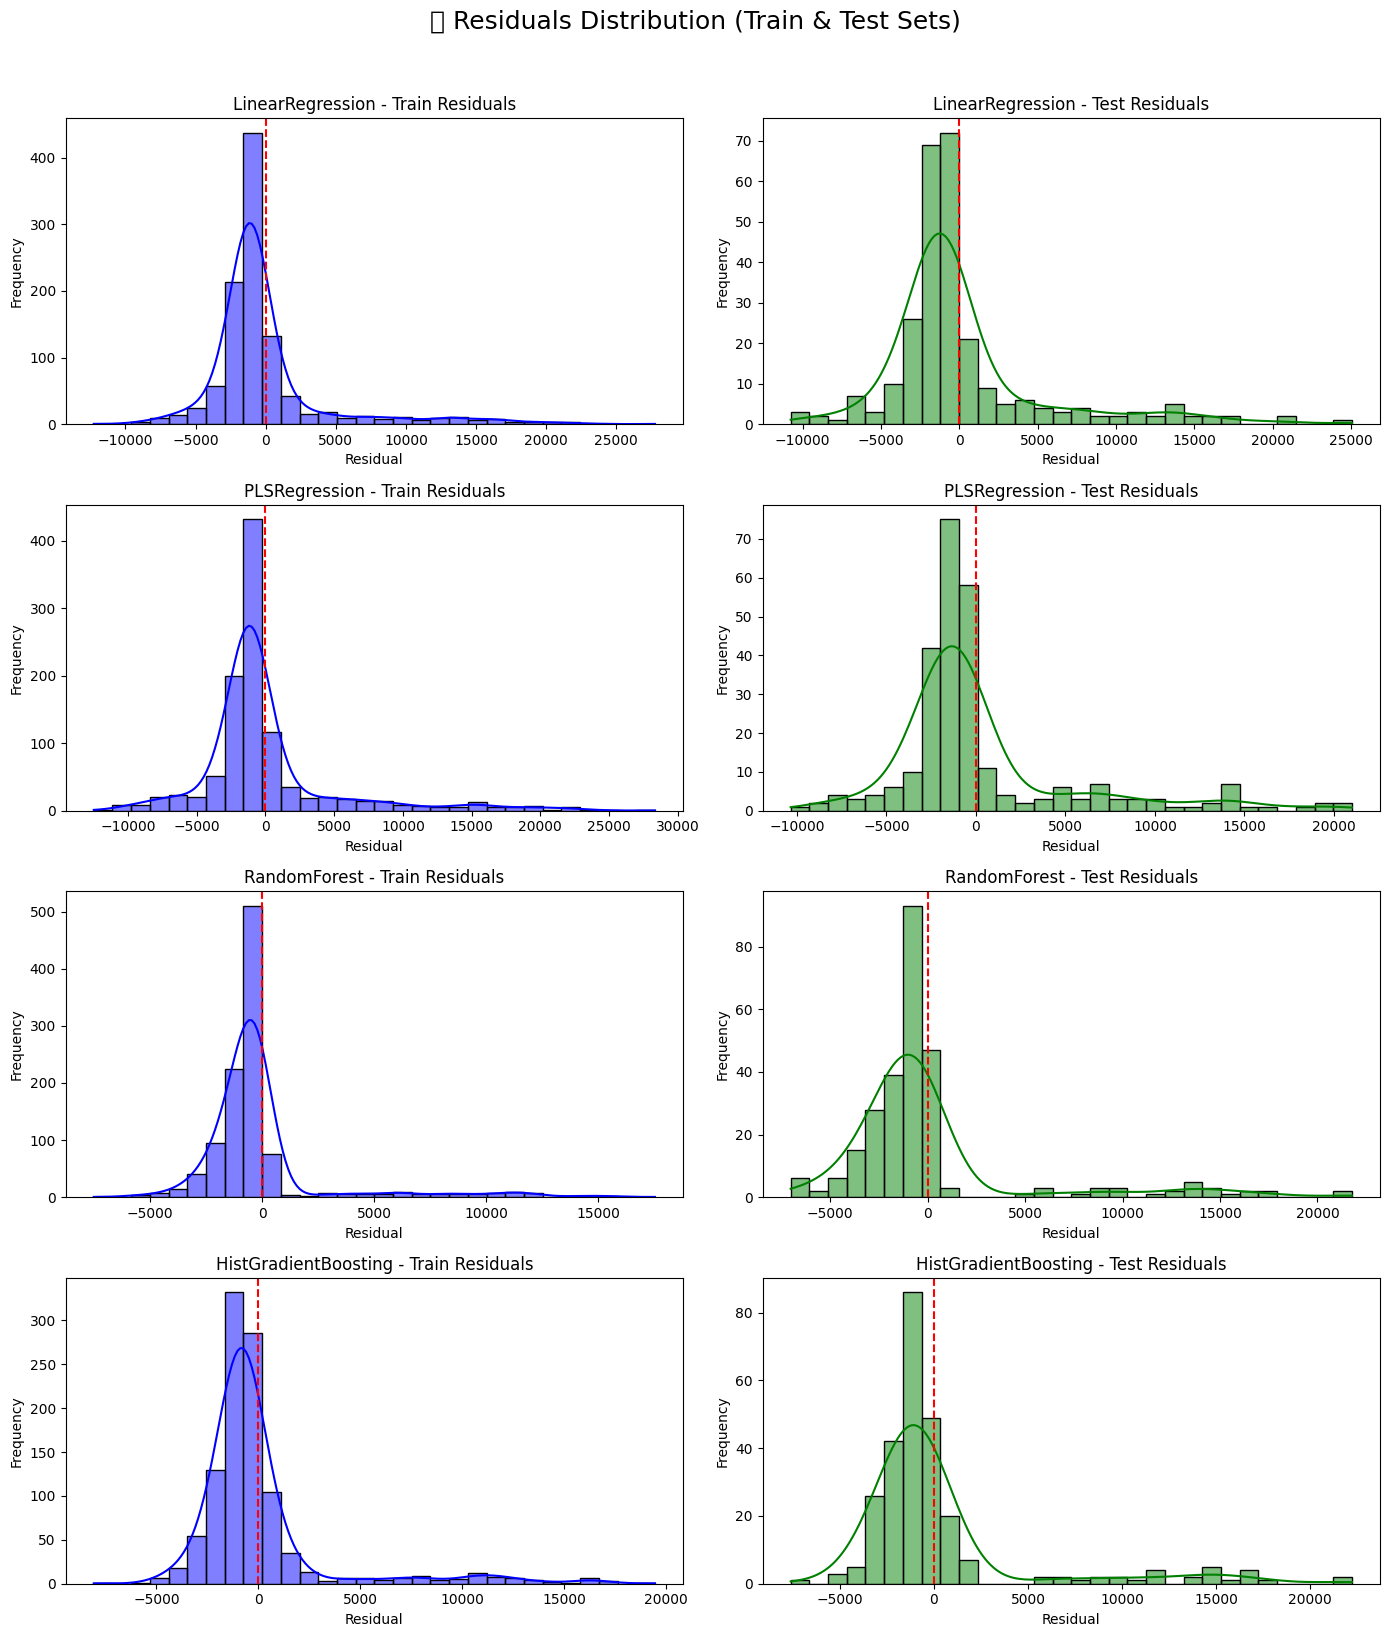

In [246]:
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()

for i, (name, model) in enumerate(best_models.items()):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    residuals_train = y_train - y_pred_train
    residuals_test = y_test - y_pred_test

    # --- Train residuals distribution ---
    ax_train = axes[2 * i]
    sns.histplot(residuals_train, kde=True, ax=ax_train, color='blue', bins=30)
    ax_train.axvline(0, color='red', linestyle='--')
    ax_train.set_title(f'{name} - Train Residuals')
    ax_train.set_xlabel('Residual')
    ax_train.set_ylabel('Frequency')

    # --- Test residuals distribution ---
    ax_test = axes[2 * i + 1]
    sns.histplot(residuals_test, kde=True, ax=ax_test, color='green', bins=30)
    ax_test.axvline(0, color='red', linestyle='--')
    ax_test.set_title(f'{name} - Test Residuals')
    ax_test.set_xlabel('Residual')
    ax_test.set_ylabel('Frequency')

plt.suptitle('📉 Residuals Distribution (Train & Test Sets)', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()